In [7]:
import numpy as np
import pandas as pd

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd /content/drive/My Drive/Projects/Sentiment Analysis
!ls

/content/drive/My Drive/Projects/Sentiment Analysis
product_reviews.csv	 sentiment_model.pkl
SentiemntAnalysis.ipynb  tfidf_vectorizer.pkl


In [10]:
#Loading the dataset
dataset = pd.read_csv('product_reviews.csv', sep=',', engine='python')
print(dataset.head())

                                              Review  Sentiment
0  This is  the best apps acording to a bunch of ...          1
1  This is a pretty good version of the game for ...          1
2  this is a really . there are a bunch of levels...          1
3  This is a silly game and can be frustrating, b...          1
4  This is a terrific game on any pad. Hrs of fun...          1


**Data Pre-Processing**

In [12]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

dataset['Cleaned_Review'] = dataset['Review'].apply(preprocess_text)

print("Original review example:", dataset['Review'].iloc[0])
print("Cleaned review example:", dataset['Cleaned_Review'].iloc[0])

Original review example: This is  the best apps acording to a bunch of people and I agree it has bombs eggs pigs TNT king pigs and realustic stuff
Cleaned review example: best app acord bunch peopl agre bomb egg pig tnt king pig realust stuff


**Feature Engineering with TF-IDF**

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2)
)

X = tfidf_vectorizer.fit_transform(dataset['Cleaned_Review'])
y = dataset['Sentiment']

print("Feature matrix shape:", X.shape)

Feature matrix shape: (19996, 5000)


**Data Split - Train-Validation-Test Split**

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [17]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)  # 0.25 * 0.8 = 0.2

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Positive sentiment ratio - Train: {y_train.mean():.2f}, Val: {y_val.mean():.2f}, Test: {y_test.mean():.2f}")


Training set size: 11997
Validation set size: 3999
Test set size: 4000
Positive sentiment ratio - Train: 0.76, Val: 0.76, Test: 0.76


**Model Training and Evaluation**

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [19]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    results[name] = {'model': model, 'accuracy': accuracy, 'f1_score': f1}
    print(f"{name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

best_model_name = max(results, key=lambda x: results[x]['f1_score'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name} with F1-Score: {results[best_model_name]['f1_score']:.4f}")


Logistic Regression - Accuracy: 0.8890, F1-Score: 0.9301
Multinomial Naive Bayes - Accuracy: 0.8730, F1-Score: 0.9215
Support Vector Machine - Accuracy: 0.8932, F1-Score: 0.9326
Random Forest - Accuracy: 0.8667, F1-Score: 0.9165

Best model: Support Vector Machine with F1-Score: 0.9326


**Hyperparameter Tuning for Best Model**

In [20]:
if best_model_name == 'Support Vector Machine':
    param_grid = {
        'C': [1, 10],
        'kernel': ['linear'],  # simplified to reduce runtime
        'gamma': ['scale']
    }
elif best_model_name == 'Logistic Regression':
    param_grid = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear']}
elif best_model_name == 'Random Forest':
    param_grid = {'n_estimators': [100], 'max_depth': [None], 'min_samples_split': [2]}
else:  # Naive Bayes
    param_grid = {'alpha': [0.5, 1.0]}

grid_search = GridSearchCV(best_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

tuned_model = grid_search.best_estimator_
print(f"Best hyperparameters: {grid_search.best_params_}")

Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


In [27]:
#To handle imbalance

svm_model = SVC(random_state=42, class_weight='balanced', kernel='linear', probability=True)

**Final Model Evaluation on Test Set**

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

FINAL PERFORMANCE ON TEST SET
Accuracy: 0.9020
F1-Score: 0.9371
              precision    recall  f1-score   support

    Negative       0.84      0.72      0.78       953
    Positive       0.92      0.96      0.94      3047

    accuracy                           0.90      4000
   macro avg       0.88      0.84      0.86      4000
weighted avg       0.90      0.90      0.90      4000



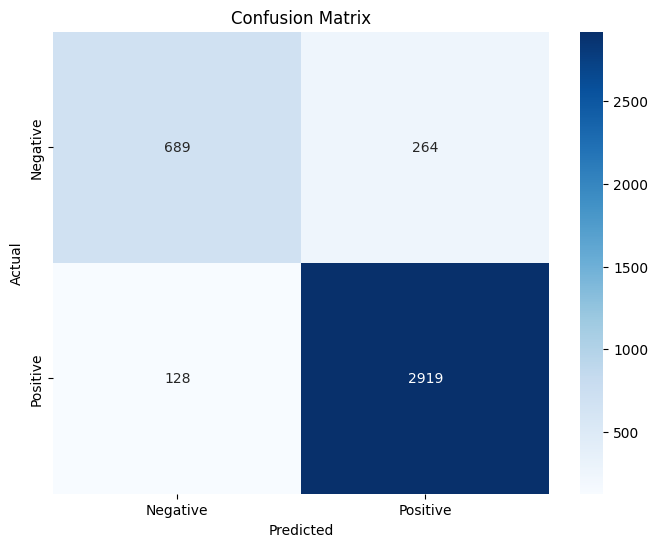

In [29]:
y_test_pred = tuned_model.predict(X_test)
print("="*50)
print("FINAL PERFORMANCE ON TEST SET")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(classification_report(y_test, y_test_pred, target_names=['Negative', 'Positive']))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


**Train Final Model on Train+Validation**

In [30]:
from scipy.sparse import vstack
X_full_train = vstack([X_train, X_val])
y_full_train = np.concatenate([y_train, y_val])
final_model = tuned_model
final_model.fit(X_full_train, y_full_train)

SVC(C=1, kernel='linear', random_state=42)

**Save Model and Vectorizer**

In [31]:
import joblib
joblib.dump(final_model, 'sentiment_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


In [32]:
import joblib

model = joblib.load('sentiment_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

text = "This product is amazing!"
cleaned_text = preprocess_text(text)
X = vectorizer.transform([cleaned_text])
prediction = model.predict(X)
print("Predicted sentiment:", "Positive" if prediction[0]==1 else "Negative")


Predicted sentiment: Positive
